# OCR
detection은 keras-ocr을 활용하고, Recognition은 직접 만들어 학습한다.

- 실습목표
1. Text Recognition 모델을 직접 구현해 봅니다.
2. Text Recognition 모델 학습을 진행해 봅니다.
3. Text Detection 모델과 연결하여 전체 OCR 시스템을 구현합니다

 ## Data Set
 1. MJSynth
 2. SynthText

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


## Recognition model(1)
Using a structure of the CRNN  
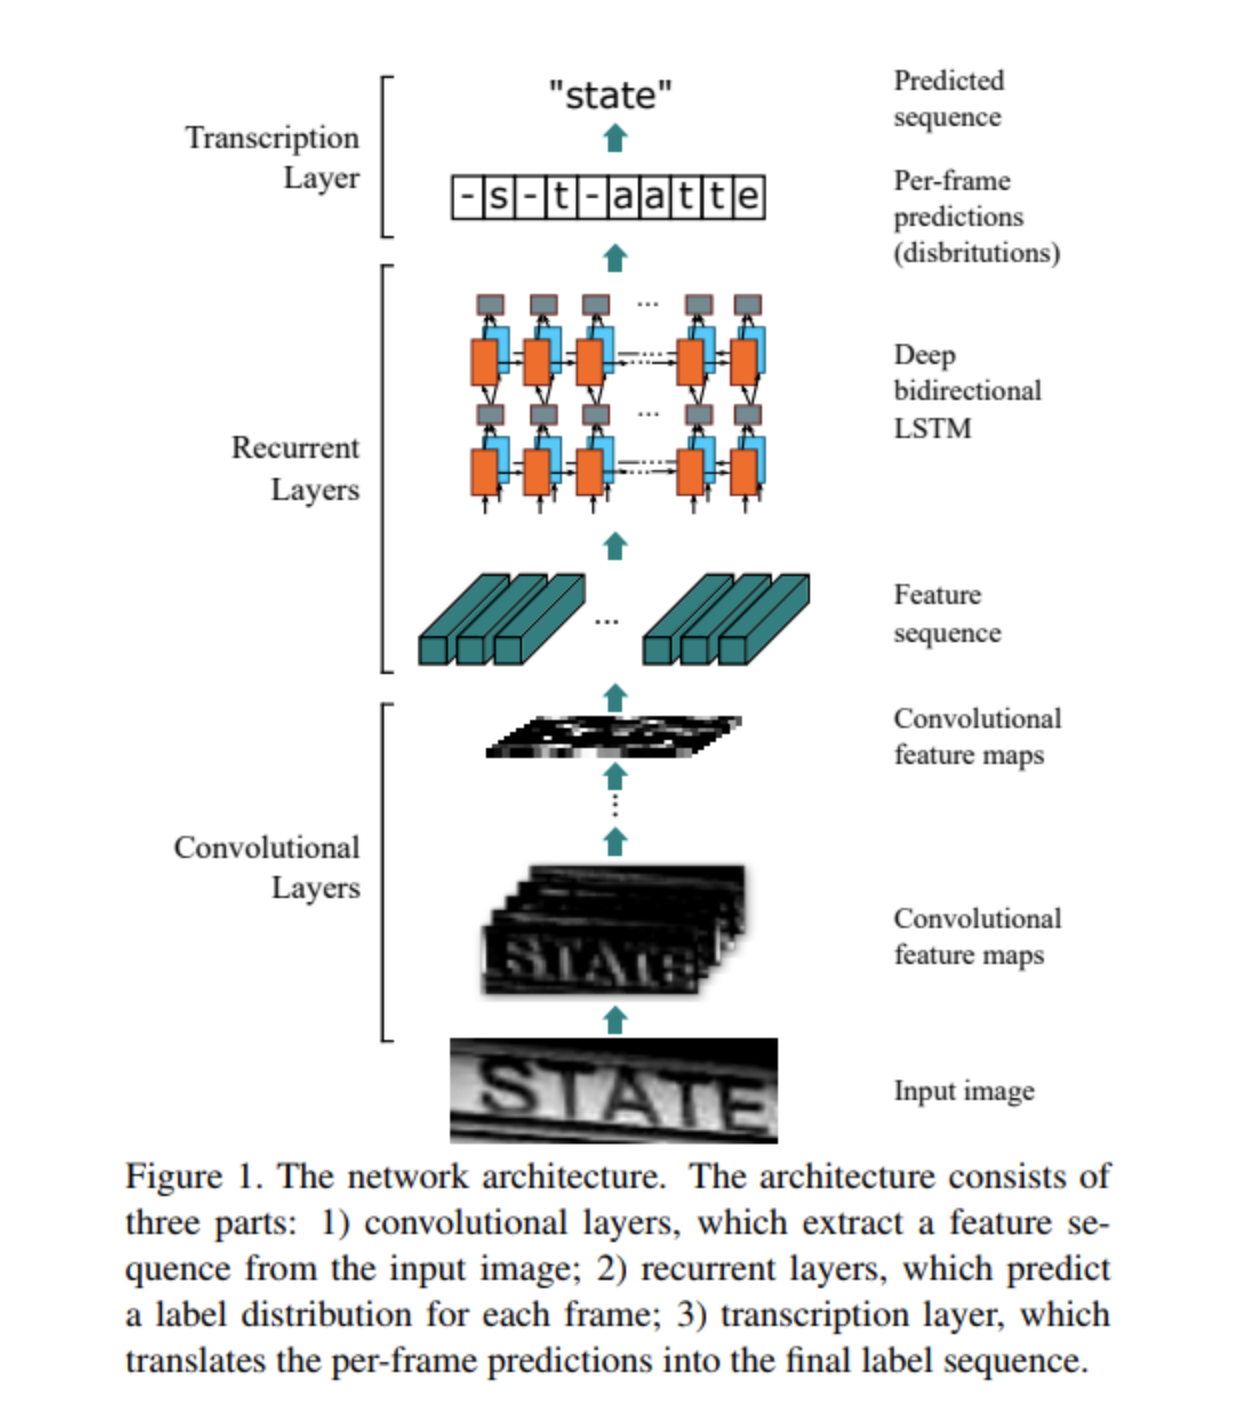




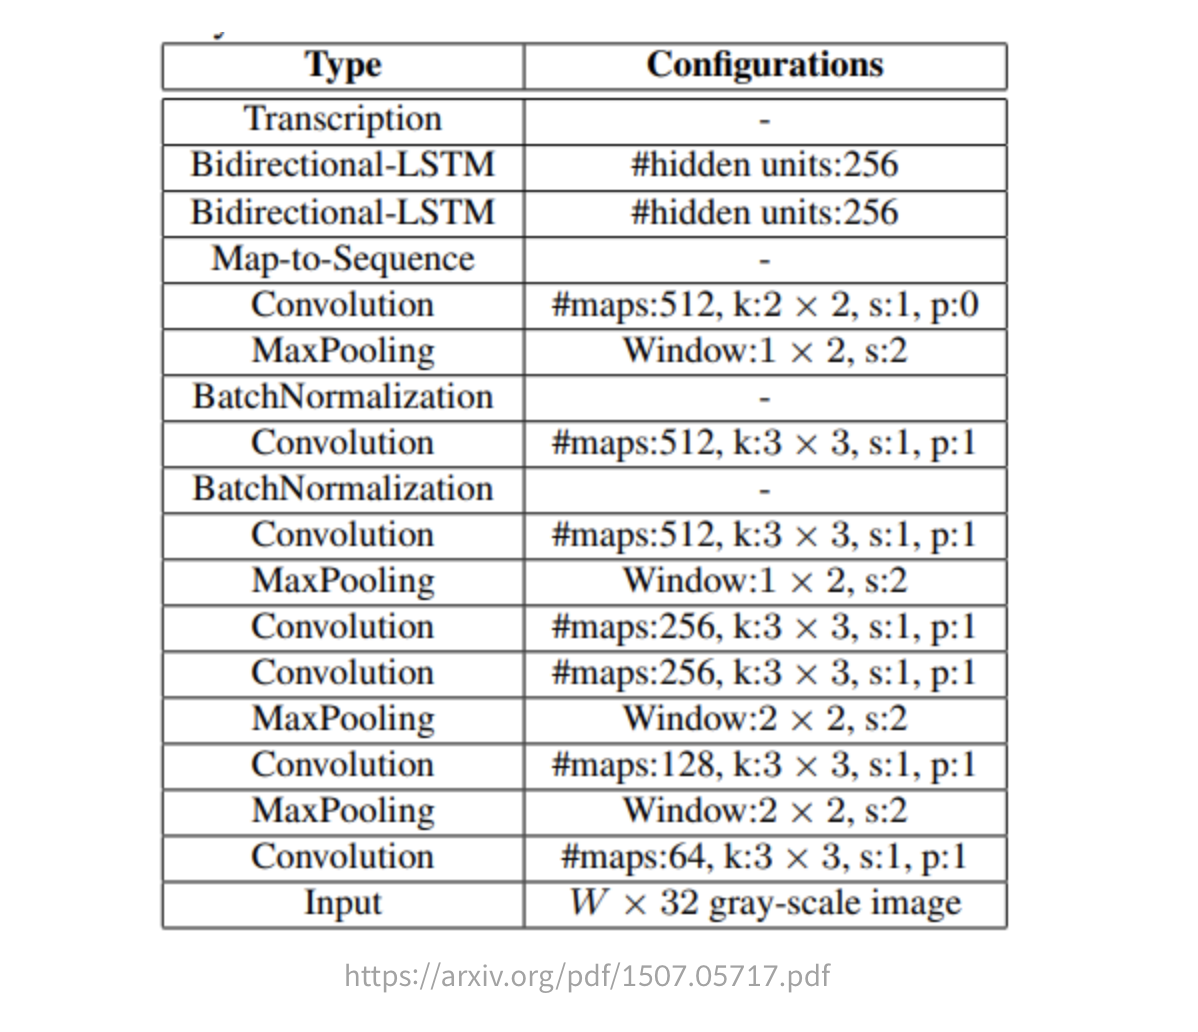

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [3]:
#import library
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


## Recognition model(2)Input Image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


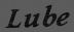

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


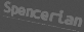

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


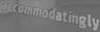

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


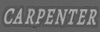

In [4]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


## Recognition model (3) Encode
모델이 학습하기 위해 인코딩을 해줘야 한다.


In [6]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         # [[YOUR CODE]] 입력받은 text를 모델이 학습할 수 있는 label로 만드는 encode() 메소드를 구현해 주세요!
# 단, 같은 글자가 연속으로 이어지는 경우에는 이어지는 그 사이에 공백 문자의 label을 포함해야 합니다!
         for i, char in enumerate(text):
            if i>0 and char == text[i-1]:
                encoded_label.append(0)
            encoded_label.append(self.label_map[char])

         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encoded_text=label_converter.encode("AIFFEL")
print('Encodeded_text: ', encoded_text)
decoded_text = label_converter.decode(encoded_text)
print('Decoded_text: ', decoded_text)

Encodeded_text:  [ 1  9  6  0  6  5 12]
Decoded_text:  AIF-FEL


##  Recognition model (4) Build CRNN model

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    print(y_pred)
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')    
    # Build CRNN model
    #(K.ctc_batch_cost()를 활용하여, image_input을 입력으로, 마지막 Label을 'output'이라는 이름으로 출력하는 
    #레이어를 갖도록 모델을 만드는 함수 build_crnn_model()을 구현해 봅시다.
    
    # Build CRNN model
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)    
    
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(x)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

## Recognition model (1)

In [10]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

Tensor("ctc/strided_slice:0", shape=(None, 22, 38), dtype=float32)


In [11]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/20
Tensor("model/ctc/strided_slice:0", shape=(None, 22, 38), dtype=float32)
Tensor("model/ctc/strided_slice:0", shape=(None, 22, 38), dtype=float32)
565/565 [==============================] - 166s 259ms/step - loss: 27.4933 - val_loss: 24.9363

Epoch 00001: val_loss improved from inf to 24.93627, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 145s 257ms/step - loss: 18.3733 - val_loss: 10.1625

Epoch 00002: val_loss improved from 24.93627 to 10.16248, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 148s 263ms/step - loss: 7.6399 - val_loss: 6.2548

Epoch 00003: val_loss improved from 10.16248 to 6.25482, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 147s 261ms/step - loss: 5.3197 - val_loss: 5.5106

Epoch 00004: val_loss improved from 6.25482 to 5.51065, saving model to /aiffel/aiffel/ocr/

In [12]:
# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Tensor("ctc/strided_slice:0", shape=(None, 22, 38), dtype=float32)


Result: 	 SLINKING9999999999999999


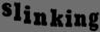

Result: 	 ALEPPO99999999999999999


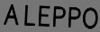

Result: 	 IFWLNDA99999999999999999


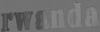

Result: 	 NATHANS99999999999999999


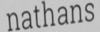

Result: 	 HALLEO99999999999999999


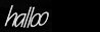

Result: 	 HURLS9999999999999999999


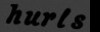

Result: 	 DOWNSIZE9999999999999999


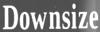

Result: 	 ROBOTIC99999999999999999


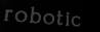

Result: 	 SLOPPY99999999999999999


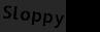

Result: 	 HERMITE99999999999999999


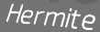

In [13]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# *프로젝트: End-to-End OCR
keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만든다.


## 루브릭
**평가문항	상세기준  
1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.  
텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.  


2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.  
학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.  


3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.  
샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.

In [14]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [15]:
def detect_text(img_path):
    # TODO
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # 배치의 첫 번째 결과만 가져옵니다.
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    image=Image.open(img_path)
    image=image.resize((640,640))
    imageDraw=ImageDraw.Draw(image)
    
    result_img = image
    
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (640, 640))
    img = img[tf.newaxis, :, :, :]
        # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    det_result = detector.detect(img.numpy())
        # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = det_result[0]
        # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    
    detector
    cropped_imgs = []
    for text_result in ocr_result:
        imageDraw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(image.crop(word_box))


    return result_img, cropped_imgs

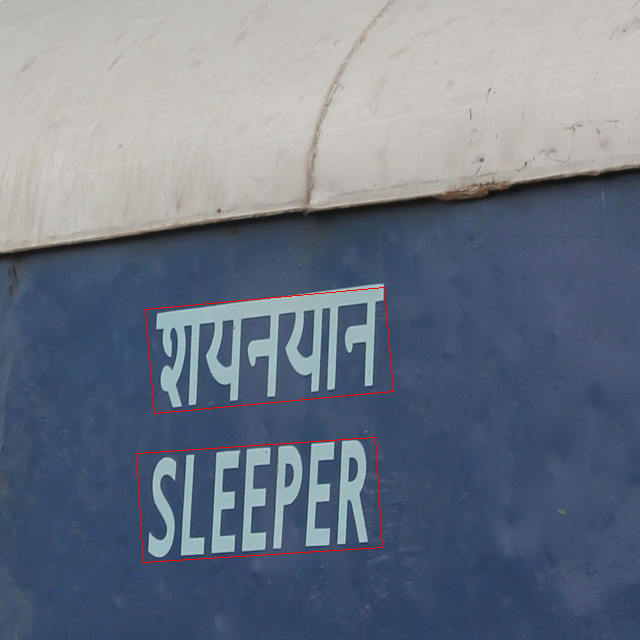

In [16]:
from PIL import Image, ImageDraw
from IPython.display import display
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [17]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 RT999999999999999999999


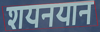

Result: 	 ISLEEPER999999999999999


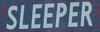

In [18]:
for _img in cropped_img:
    recognize_img(_img)

# 회고
CNN과 RNN이 합쳐진 CRNN을 사용해봤다. 
Convolution으로 feature를 추출했고, feature들을 시퀀셜하게 만들어 LSTM에 통과시켜  
text recognition에서 맥락을 고려할 수 있게 만들었다.  
OCR분야는 지금도 진화하고 있고, LSTM에서 Attention과 Transformer 영역으로 넘어가  
계속적으로 발전적인 모습을 보여주고 있다.